In [1]:
require(rpart)
require(randomForest)
require(RColorBrewer)
require(rattle)
require(rpart.plot)
require(party)
require(caret)
pal.img <- brewer.pal(11, "Oranges")

Loading required package: rpart
Loading required package: randomForest
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.
Loading required package: RColorBrewer
Loading required package: rattle
Rattle: A free graphical interface for data mining with R.
Versión 4.1.0 Copyright (c) 2006-2015 Togaware Pty Ltd.
Escriba 'rattle()' para agitar, sacudir y  rotar sus datos.
Loading required package: rpart.plot
Loading required package: party
Loading required package: grid
Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich
Loading required package: caret
Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘ggplot2’

The following object is masked from ‘package:randomForest’:

In [2]:
set.seed(3)
d.all <- read.csv(file.path("..","data", "final", "noisy.csv"))

sample_size <- floor(0.75 * nrow(d.all))

d.train_ind <- sample(seq_len(nrow(d.all)), size = sample_size)

d.train <- d.all[d.train_ind, ]
d.test  <- d.all[-d.train_ind, ]

In [3]:
head(d.all)

ID,magnitude,Cadence,duration,latitude,longitude,Teff,Teff_error,logg,logg_error,Type,var_lc,num_peaks,median_peaks,mad_peaks
1,7.6,1800,27.40,23.83,1.70,5581,200,-999.00,-999.0,Trans/Eclipse,8.049337e+05,1,25.48420,0.00000
2,7.5,1800,27.38,33.21,332.88,6916,300,-999.00,-999.0,Trans/Eclipse,3.274895e+08,4,34.50920,21.47597
3,11.3,120,27.40,39.91,128.06,13121,100,4.14,0.1,SPB,2.941730e+03,8,84.89471,40.16292
4,8.3,1800,27.38,19.66,235.53,7797,200,-999.00,-999.0,Trans/Eclipse,NA,NA,NA,NA
5,12.7,1800,54.77,56.89,243.21,7305,239,4.17,0.4,dSct+gDor hybrid,4.176992e+01,4,18.12977,15.56164
6,16.2,1800,27.40,14.13,27.02,4633,200,2.98,0.1,Solar-like,3.351859e-01,2,11.25552,14.16858


## Simple decision tree

Warning message in polygon(x[, i], y[, i], col = col[i], border = border.col[i], :
“semi-transparencia no esta soportado en este dispositivo: reportado solo una vez por pagina”

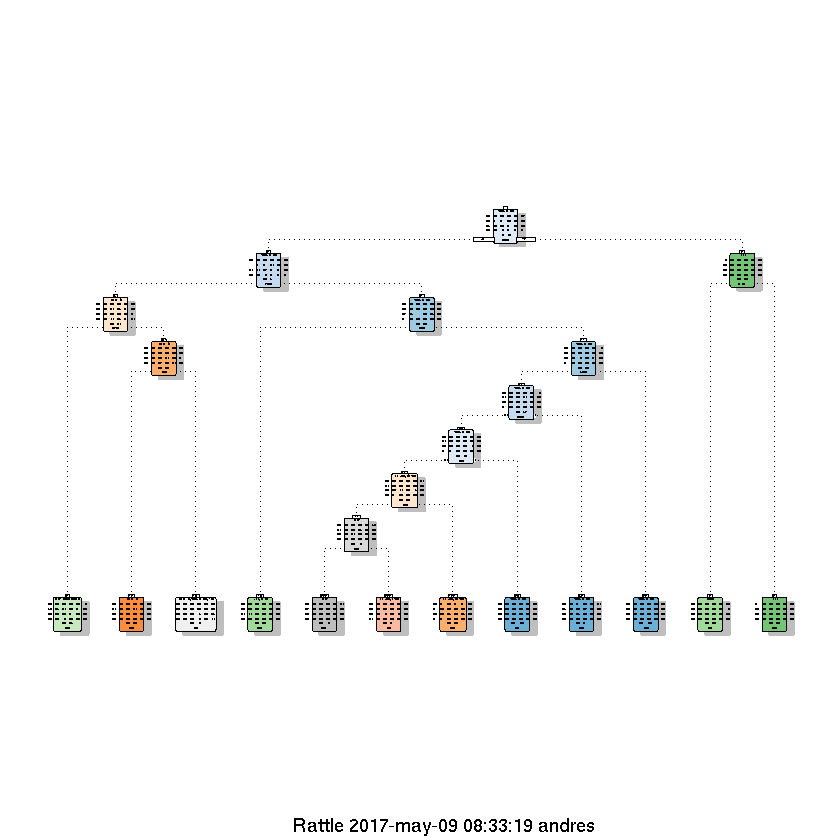

In [4]:
fit.tree <- rpart(Type ~ magnitude + Teff + logg + var_lc + num_peaks + median_peaks + mad_peaks,
                  data = d.train, method = "class")
fit.tree.prediction <- predict(fit.tree, d.test, type = "class")
fancyRpartPlot(fit.tree)

In [5]:
paste("Training error:",
      sum(predict(fit.tree, d.train, type = "class") == d.train$Type) / nrow(d.train) * 100, "%")
paste("Prediction error:",
      sum(predict(fit.tree, d.test, type = "class") == d.test$Type) / nrow(d.test) * 100, "%")

[1] "Training error: 78.08 %"

[1] "Prediction error: 75.04 %"

## Random forest

In [6]:
d.all.fix <- na.roughfix(d.all)
d.train <- d.all.fix[d.train_ind, ]
d.test  <- d.all.fix[-d.train_ind, ]

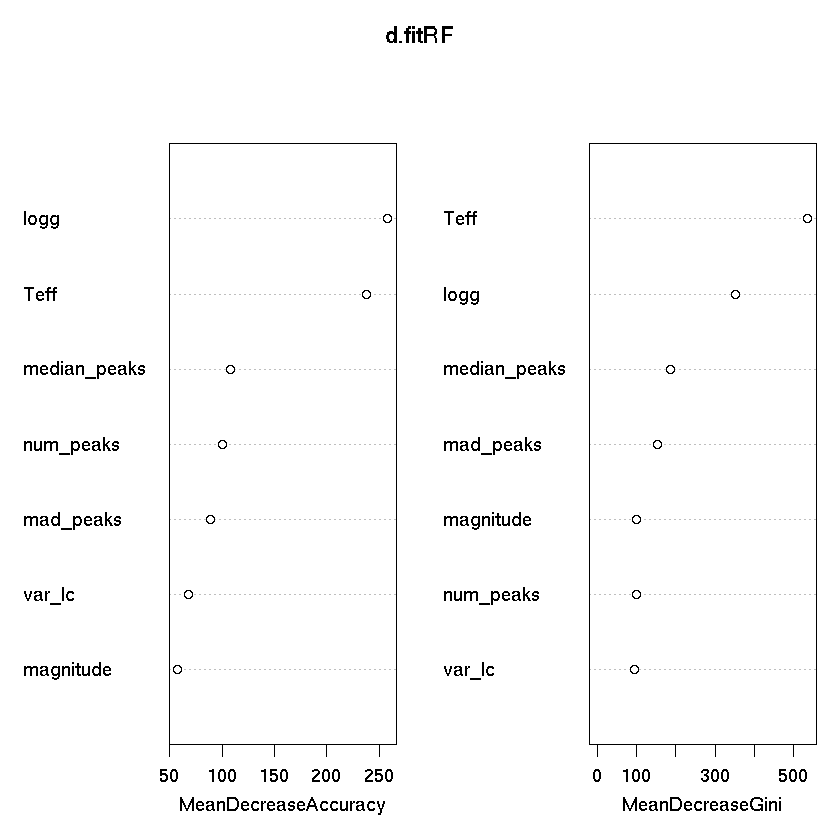

In [7]:
d.fitRF <- randomForest(Type ~ magnitude + Teff + logg + num_peaks + var_lc + median_peaks + mad_peaks,
                        data = d.train,
                        importance = TRUE, ntree = 2000)
varImpPlot(d.fitRF)

### Confusion matrix

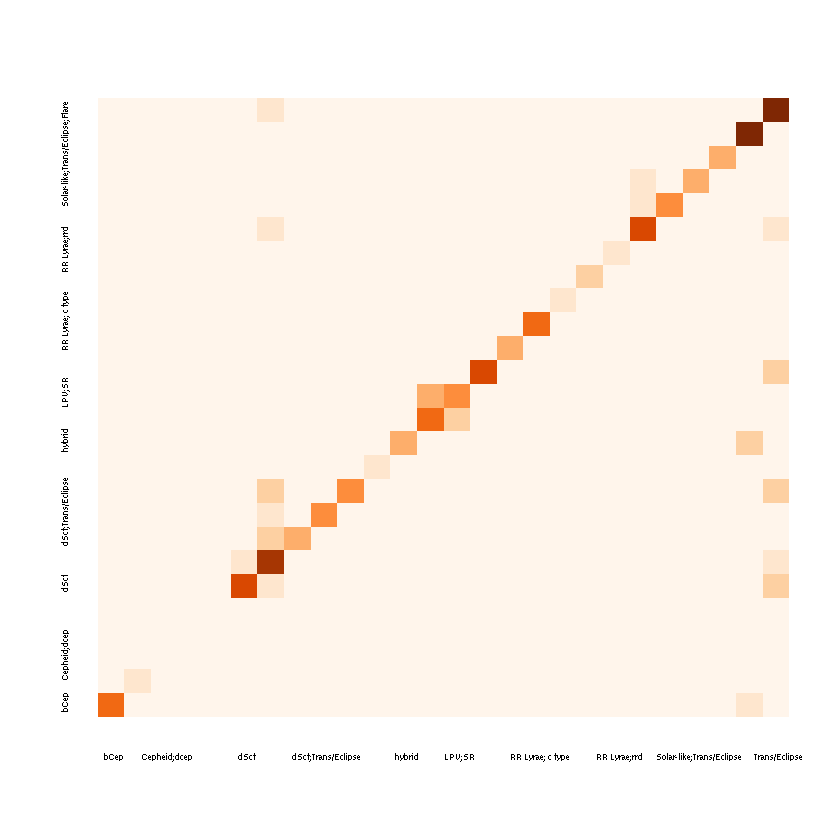

In [8]:
cm <- as.matrix(confusionMatrix(reference = d.all$Type, data = predict(d.fitRF, d.all, type = "class"))$table)
image(1:ncol(cm), 1:nrow(cm), log(1+cm), col = pal.img, axes=FALSE,xlab="",ylab="",srt=45)
axis(1, at = 1:ncol(cm), labels=colnames(cm),srt=45,tick=FALSE, cex.axis = 0.4)
axis(2, at = 1:nrow(cm), labels=rownames(cm),srt=45,tick=FALSE, cex.axis = 0.4)

In [9]:
paste("Training error:",
      sum(predict(d.fitRF, newdata = d.train) == d.train$Type) / nrow(d.train) * 100, "%")
paste("Prediction error:",
      sum(predict(d.fitRF, newdata = d.test) == d.test$Type) / nrow(d.test) * 100, "%")

[1] "Training error: 99.0933333333333 %"

[1] "Prediction error: 83.2 %"